# Sentiment Analysis

## Loading Data & Descriptive Analysis

In [0]:
import numpy as np
import pandas as pd

In [0]:
train_df = pd.read_csv("/content/review_train.csv")

In [0]:
test_df = pd.read_csv("/content/review_test.csv")

In [4]:
train_df.columns.difference(test_df.columns)

Index([], dtype='object')

In [5]:
train_df.shape

(14825, 3)

In [6]:
test_df.shape

(3707, 3)

In [0]:
train_df["Source"] = "train"
test_df["Source"] = "test"

In [8]:
train_df.columns

Index(['Text', 'Score', 'Sentiment', 'Source'], dtype='object')

In [9]:
test_df.columns

Index(['Text', 'Score', 'Sentiment', 'Source'], dtype='object')

In [0]:
df = pd.concat([train_df, test_df])

In [11]:
df.shape

(18532, 4)

In [12]:
df.head()

,Text,Score,Sentiment,Source
0,"I got a free sample of these once, and now--we...",5,1,train
1,I used to get this Tea when I lived in Washing...,4,1,train
2,This is my all time favorite 'grab and go' sna...,5,1,train
3,This flavor is very good and unexpected. The ...,4,1,train
4,thrilled to have this assortment as i got the ...,4,1,train


In [13]:
df.tail()

,Text,Score,Sentiment,Source
3702,I always have Powerade in the house - for ever...,5,1,test
3703,I tried this coffee on a half dozen quests thi...,5,1,test
3704,The Neccos were exactly what I expected and fr...,5,1,test
3705,I thought I was doing the right thing by getti...,1,0,test
3706,Cugino's chicken noodle soup is pretty tasty. ...,5,1,test


In [14]:
df.describe()

,Score,Sentiment
count,18532.000000,18532.000000
mean,4.277304,0.843784
std,1.319827,0.363070
min,1.000000,0.000000
25%,4.000000,1.000000
50%,5.000000,1.000000
75%,5.000000,1.000000
max,5.000000,1.000000


## EDA

In [15]:
df.Score.value_counts()

5    12795
4     2842
1     1866
2     1029
Name: Score, dtype: int64

In [16]:
df.Sentiment.value_counts()

1    15637
0     2895
Name: Sentiment, dtype: int64

In [17]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Score,18532.0,4.277304,1.319827,1.0,4.0,5.0,5.0,5.0
Sentiment,18532.0,0.843784,0.363070,0.0,1.0,1.0,1.0,1.0


In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18532 entries, 0 to 3706
Data columns (total 4 columns):
Text         18532 non-null object
Score        18532 non-null int64
Sentiment    18532 non-null int64
Source       18532 non-null object
dtypes: int64(2), object(2)
memory usage: 723.9+ KB


In [0]:
import matplotlib.pyplot as plt
%matplotlib inline

In [0]:
import seaborn as sns

Text(0.5, 1.0, 'Scores Distribution')

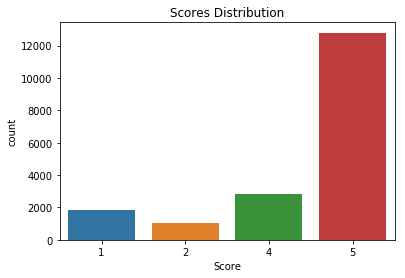

In [21]:
sns.countplot(x='Score', data=df)
plt.title("Scores Distribution")
# sns.barplot(x = df.Score.value_counts().index, y = df.Score.value_counts())

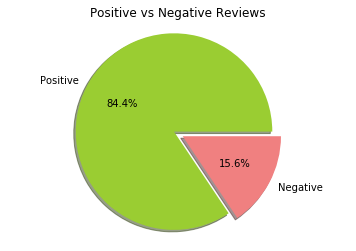

In [22]:
labels = 'Positive', 'Negative'
sizes = df.Sentiment.value_counts()
colors = ['yellowgreen', 'lightcoral']
explode = (0, 0.1)  # explode 1st slice

# Plot
plt.pie(sizes, explode=explode, labels=labels, colors=colors,
autopct='%1.1f%%', shadow=True, startangle=0)
plt.title("Positive vs Negative Reviews")

plt.axis('equal')
plt.show()

In [23]:
corr = df.corr()
print(corr)

              Score  Sentiment
Score      1.000000   0.952582
Sentiment  0.952582   1.000000


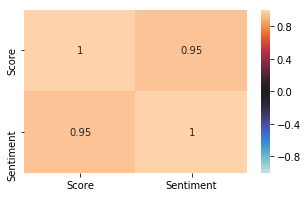

In [24]:
plt.figure(figsize=(5,3))
ax = sns.heatmap(corr,vmin=-1,vmax=1,center=0,annot=True)

## Data Preprocessing

In [25]:
df.isna().sum()

Text         0
Score        0
Sentiment    0
Source       0
dtype: int64

In [26]:
df.duplicated().sum()

433

In [0]:
# reviews = np.array(df['Text'])
# sentiments = np.array(df['Sentiment'])

In [28]:
df.columns

Index(['Text', 'Score', 'Sentiment', 'Source'], dtype='object')

In [29]:
# Removing 'Score' column as it is not needed

df.drop(columns=['Score'], inplace=True)
df.columns

Index(['Text', 'Sentiment', 'Source'], dtype='object')

In [0]:
train_final = df[df.Source=="train"]
test_final = df[df.Source=="test"]

In [0]:
train_reviews = train_final['Text'].values
train_sentiments = train_final['Sentiment'].values

test_reviews = test_final['Text'].values
test_sentiments = test_final['Sentiment'].values

### Text Preprocessor (No need to do Stop word removal for Sentiment Analysis)

In [32]:
!pip install textsearch
!pip install contractions
!pip install tqdm

In [33]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [34]:
!pip install spacy
import spacy

In [35]:
!python -m spacy validate

✔ Loaded compatibility table

====================== Installed models (spaCy v2.1.8) ======================
ℹ spaCy installation: /usr/local/lib/python3.6/dist-packages/spacy

TYPE      NAME             MODEL            VERSION                            
package   en-core-web-sm   en_core_web_sm   2.1.0   ✔
link      en               en_core_web_sm   2.1.0   ✔



In [36]:
!python -m spacy download en

✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')
✔ Linking successful
/usr/local/lib/python3.6/dist-packages/en_core_web_sm -->
/usr/local/lib/python3.6/dist-packages/spacy/data/en
You can now load the model via spacy.load('en')


In [0]:
import re
from bs4 import BeautifulSoup
import unicodedata
import contractions
import spacy

nlp = spacy.load('en')
ps = nltk.porter.PorterStemmer()


def strip_html_tags(text):
    soup = BeautifulSoup(text, "html.parser")
    [s.extract() for s in soup(['iframe', 'script'])]
    stripped_text = soup.get_text()
    stripped_text = re.sub(r'[\r|\n|\r\n]+', '\n', stripped_text)
    return stripped_text


def remove_accented_chars(text):
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    return text


def expand_contractions(text):
    return contractions.fix(text)


def spacy_lemmatize_text(text):
    text = nlp(text)
    text = ' '.join([word.lemma_ if word.lemma_ != '-PRON-' else word.text for word in text])
    return text


def simple_stemming(text, stemmer=ps):
    text = ' '.join([stemmer.stem(word) for word in text.split()])
    return text


def remove_special_characters(text, remove_digits=False):
    pattern = r'[^a-zA-Z0-9\s]' if not remove_digits else r'[^a-zA-Z\s]'
    text = re.sub(pattern, '', text)
    return text


def remove_stopwords(text, is_lower_case=False, stopwords=None):
    if not stopwords:
        stopwords = nltk.corpus.stopwords.words('english')
    tokens = nltk.word_tokenize(text)
    tokens = [token.strip() for token in tokens]
    
    if is_lower_case:
        filtered_tokens = [token for token in tokens if token not in stopwords]
    else:
        filtered_tokens = [token for token in tokens if token.lower() not in stopwords]
    
    filtered_text = ' '.join(filtered_tokens)    
    return filtered_text

In [0]:
import tqdm

def text_pre_processor(text, html_strip=True, accented_char_removal=True, contraction_expansion=True,
                       text_lower_case=True, text_stemming=False, text_lemmatization=True, 
                       special_char_removal=True, remove_digits=True, stopword_removal=False, 
                       stopword_list=None):
    
    # strip HTML
    if html_strip:
        text = strip_html_tags(text)
    
    # remove extra newlines (often might be present in really noisy text)
    text = text.translate(text.maketrans("\n\t\r", "   "))
    
    # remove accented characters
    if accented_char_removal:
        text = remove_accented_chars(text)
    
    # expand contractions    
    if contraction_expansion:
        text = expand_contractions(text)
        
#     # expand contractions without Contraction library (Custom Code)
#     if contraction_expansion:
#         text = expandContractions(text)
    
    # lemmatize text
    if text_lemmatization:
        text = spacy_lemmatize_text(text) 
        
    # remove special characters and\or digits    
    if special_char_removal:
        # insert spaces between special characters to isolate them    
        special_char_pattern = re.compile(r'([{.(-)!}])')
        text = special_char_pattern.sub(" \\1 ", text)
        text = remove_special_characters(text, remove_digits=remove_digits)  
        
    # stem text
    if text_stemming and not text_lemmatization:
        text = simple_stemming(text)
        
    # lowercase the text    
    if text_lower_case:
        text = text.lower()
        
        
    # remove stopwords
    if stopword_removal:
        text = remove_stopwords(text, is_lower_case=text_lower_case, 
                                stopwords=stopword_list)
        
    # remove extra whitespace
    text = re.sub(' +', ' ', text)
    text = text.strip()
    
    return text

In [0]:
def pre_process(reviews):
  norm_reviews = []
  for review in tqdm.tqdm(reviews):
    review = text_pre_processor(review)  #Stop word removal is already set to False, as we are doing Sentiment Analysis
    norm_reviews.append(review)
  return norm_reviews

### Creating Normalised Data using Text Preprocessor


In [55]:
%%time

norm_train_reviews = pre_process(train_reviews)
norm_test_reviews = pre_process(test_reviews)

100%|██████████| 3707/3707 [01:16<00:00, 48.61it/s]

CPU times: user 6min 32s, sys: 3.27 s, total: 6min 36s
Wall time: 6min 35s


In [80]:
[review[0:100] for review in train_reviews[0:5]]

["I got a free sample of these once, and now--we're on the subscribe and save program.  Not much of a ",
 'I used to get this Tea when I lived in Washington State and missed it.  A niece told me it was avail',
 "This is my all time favorite 'grab and go' snack bar. It doesn't leave you with a sugar rush/drop, t",
 'This flavor is very good and unexpected.  The flavor of the cheese and garlic go well together and t',
 'thrilled to have this assortment as i got the chance to choose another decaf coffee- have already sa']

In [81]:
[review[0:100] for review in norm_train_reviews[0:5]]

['i get a free sample of these once and now we be on the subscribe and save program not much of a chip',
 'i use to get this tea when i live in washington state and miss it a niece tell me it be available at',
 'this be my all time favorite grab and go snack bar it do not leave you with a sugar rush drop taste ',
 'this flavor be very good and unexpected the flavor of the cheese and garlic go well together and the',
 'thrill to have this assortment as i get the chance to choose another decaf coffee have already sampl']

## Feature Engineering

In [82]:
%%time

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# build BOW features on train reviews
cv = CountVectorizer(binary=False, min_df=5, max_df=1.0, ngram_range=(1,2))

cv_train_features = cv.fit_transform(norm_train_reviews)


# build TFIDF features on train reviews
tv = TfidfVectorizer(use_idf=True, min_df=5, max_df=1.0, ngram_range=(1,2),
                     sublinear_tf=True)
tv_train_features = tv.fit_transform(norm_train_reviews)

CPU times: user 6.83 s, sys: 85.9 ms, total: 6.92 s
Wall time: 6.93 s


In [83]:
%%time

# transform test reviews into features
cv_test_features = cv.transform(norm_test_reviews)
tv_test_features = tv.transform(norm_test_reviews)

CPU times: user 985 ms, sys: 5.97 ms, total: 991 ms
Wall time: 990 ms


In [84]:
print('BOW model:> Train features shape:', cv_train_features.shape, ' Test features shape:', cv_test_features.shape)
print('TFIDF model:> Train features shape:', tv_train_features.shape, ' Test features shape:', tv_test_features.shape)

BOW model:> Train features shape: (14825, 35004)  Test features shape: (3707, 35004)
TFIDF model:> Train features shape: (14825, 35004)  Test features shape: (3707, 35004)


## Modeling

### Using Logistic Regression

In [85]:
%%time

# Logistic Regression model on BOW features
from sklearn.linear_model import LogisticRegression

# instantiate model
lr = LogisticRegression(penalty='l2', max_iter=500, C=1, solver='lbfgs', random_state=42)

# train model
lr.fit(cv_train_features, train_sentiments)

# predict on test data
lr_bow_predictions = lr.predict(cv_test_features)

CPU times: user 5.02 s, sys: 3.31 s, total: 8.33 s
Wall time: 4.25 s


In [86]:
from sklearn.metrics import confusion_matrix, classification_report

labels = ['negative', 'positive']
print(classification_report(test_sentiments, lr_bow_predictions))
pd.DataFrame(confusion_matrix(test_sentiments, lr_bow_predictions), index=labels, columns=labels)

              precision    recall  f1-score   support

           0       0.83      0.69      0.76       592
           1       0.94      0.97      0.96      3115

    accuracy                           0.93      3707
   macro avg       0.89      0.83      0.86      3707
weighted avg       0.93      0.93      0.93      3707



,negative,positive
negative,410,182
positive,83,3032


### Using Random Forest

In [90]:
%%time

# Random Forest model on BOW features
from sklearn.ensemble import RandomForestClassifier

# instantiate model
rf = RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=42)

# train model
rf.fit(cv_train_features, train_sentiments)

# predict on test data
rf_bow_predictions = rf.predict(cv_test_features)

CPU times: user 24.3 s, sys: 71.2 ms, total: 24.4 s
Wall time: 12.6 s


In [91]:
labels = ['negative', 'positive']
print(classification_report(test_sentiments, rf_bow_predictions))
pd.DataFrame(confusion_matrix(test_sentiments, rf_bow_predictions), index=labels, columns=labels)

              precision    recall  f1-score   support

           0       0.98      0.20      0.34       592
           1       0.87      1.00      0.93      3115

    accuracy                           0.87      3707
   macro avg       0.93      0.60      0.63      3707
weighted avg       0.89      0.87      0.84      3707



,negative,positive
negative,121,471
positive,2,3113


In [92]:
%%time

# Random Forest model on TF-IDF features

# train model
rf.fit(tv_train_features, train_sentiments)

# predict on test data
rf_tfidf_predictions = rf.predict(tv_test_features)

CPU times: user 26.3 s, sys: 40.6 ms, total: 26.4 s
Wall time: 13.5 s


In [93]:
labels = ['negative', 'positive']
print(classification_report(test_sentiments, rf_tfidf_predictions))
pd.DataFrame(confusion_matrix(test_sentiments, rf_tfidf_predictions), index=labels, columns=labels)

              precision    recall  f1-score   support

           0       1.00      0.21      0.34       592
           1       0.87      1.00      0.93      3115

    accuracy                           0.87      3707
   macro avg       0.93      0.60      0.64      3707
weighted avg       0.89      0.87      0.84      3707



,negative,positive
negative,123,469
positive,0,3115


### Using Newer Supervised Deep Learning Models

In [0]:
import gensim
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout, Activation, Dense
from sklearn.preprocessing import LabelEncoder

#### Prediction class label encoding

In [0]:
le = LabelEncoder()
# tokenize train reviews & encode train labels
tokenized_train = [nltk.word_tokenize(text)
                       for text in norm_train_reviews]
y_train = le.fit_transform(train_sentiments)
# tokenize test reviews & encode test labels
tokenized_test = [nltk.word_tokenize(text)
                       for text in norm_test_reviews]
y_test = le.fit_transform(test_sentiments)

In [116]:
# print class label encoding map and encoded labels
print('Sentiment class label map:', dict(zip(le.classes_, le.transform(le.classes_))), '\n')
print('Sample test label transformation (First 30 records):\n'+'-'*80,
      '\nActual Labels :', test_sentiments[:30], '\nEncoded Labels:', y_test[:30], '\n')
print('Sample test label transformation (Last 30 records):\n'+'-'*80,
      '\nActual Labels :', test_sentiments[len(test_sentiments)-30:], '\nEncoded Labels:', y_test[len(test_sentiments)-30:])

Sentiment class label map: {0: 0, 1: 1} 

Sample test label transformation (First 30 records):
-------------------------------------------------------------------------------- 
Actual Labels : [1 1 1 1 1 1 1 1 1 1 1 0 0 1 0 1 0 0 1 1 1 1 1 0 1 0 1 1 1 1] 
Encoded Labels: [1 1 1 1 1 1 1 1 1 1 1 0 0 1 0 1 0 0 1 1 1 1 1 0 1 0 1 1 1 1] 

Sample test label transformation (Last 30 records):
-------------------------------------------------------------------------------- 
Actual Labels : [1 1 0 1 1 0 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1] 
Encoded Labels: [1 1 0 1 1 0 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1]


### Feature Engineering with word embeddings

In [0]:
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [118]:
%%time
# build word2vec model
w2v_num_features = 300
w2v_model = gensim.models.Word2Vec(tokenized_train, size=w2v_num_features, window=150,
                                   min_count=10, workers=4, iter=5)

2019-09-19 14:00:34,197 : INFO : collecting all words and their counts
2019-09-19 14:00:34,198 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2019-09-19 14:00:34,339 : INFO : PROGRESS: at sentence #10000, processed 793898 words, keeping 16758 word types
2019-09-19 14:00:34,408 : INFO : collected 20360 word types from a corpus of 1177527 raw words and 14825 sentences
2019-09-19 14:00:34,409 : INFO : Loading a fresh vocabulary
2019-09-19 14:00:34,440 : INFO : effective_min_count=10 retains 4184 unique words (20% of original 20360, drops 16176)
2019-09-19 14:00:34,441 : INFO : effective_min_count=10 leaves 1141504 word corpus (96% of original 1177527, drops 36023)
2019-09-19 14:00:34,458 : INFO : deleting the raw counts dictionary of 20360 items
2019-09-19 14:00:34,460 : INFO : sample=0.001 downsamples 59 most-common words
2019-09-19 14:00:34,461 : INFO : downsampling leaves estimated 778079 word corpus (68.2% of prior 1141504)
2019-09-19 14:00:34,474 : INFO : 

CPU times: user 1min, sys: 110 ms, total: 1min
Wall time: 30.7 s


In [0]:
def averaged_word2vec_vectorizer(corpus, model, num_features):
    vocabulary = set(model.wv.index2word)
    
    def average_word_vectors(words, model, vocabulary, num_features):
        feature_vector = np.zeros((num_features,), dtype="float64")
        nwords = 0.
        
        for word in words:
            if word in vocabulary: 
                nwords = nwords + 1.
                feature_vector = np.add(feature_vector, model.wv[word])
        if nwords:
            feature_vector = np.divide(feature_vector, nwords)

        return feature_vector

    features = [average_word_vectors(tokenized_sentence, model, vocabulary, num_features)
                    for tokenized_sentence in corpus]
    return np.array(features)

In [0]:
# generate averaged word vector features from word2vec model
avg_wv_train_features = averaged_word2vec_vectorizer(corpus=tokenized_train, model=w2v_model,
                                                     num_features=w2v_num_features)
avg_wv_test_features = averaged_word2vec_vectorizer(corpus=tokenized_test, model=w2v_model,
                                                    num_features=w2v_num_features)

In [121]:
print('Word2Vec model:> Train features shape:', avg_wv_train_features.shape, ' Test features shape:', avg_wv_test_features.shape)

Word2Vec model:> Train features shape: (14825, 300)  Test features shape: (3707, 300)


### Modeling with deep neural networks 

#### Building Deep neural network architecture

In [0]:
def construct_deepnn_architecture(num_input_features):
    dnn_model = Sequential()
    dnn_model.add(Dense(512, input_shape=(num_input_features,)))
    dnn_model.add(Activation('relu'))
    dnn_model.add(Dropout(0.2))
    
    dnn_model.add(Dense(256))
    dnn_model.add(Activation('relu'))
    dnn_model.add(Dropout(0.2))
    
    dnn_model.add(Dense(256))
    dnn_model.add(Activation('relu'))
    dnn_model.add(Dropout(0.2))
    
    dnn_model.add(Dense(1))
    dnn_model.add(Activation('sigmoid'))

    dnn_model.compile(loss='binary_crossentropy', optimizer='adam',                 
                      metrics=['accuracy'])
    return dnn_model

In [123]:
w2v_dnn = construct_deepnn_architecture(num_input_features=w2v_num_features)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


2019-09-19 14:01:40,870 : WARNING : From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


2019-09-19 14:01:41,105 : WARNING : From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


#### Visualize sample deep architecture

In [124]:
w2v_dnn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 512)               154112    
_________________________________________________________________
activation (Activation)      (None, 512)               0         
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
_________________________________________________________________
activation_1 (Activation)    (None, 256)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               6

#### Model Training, Prediction and Performance Evaluation

In [125]:
batch_size = 100
w2v_dnn.fit(avg_wv_train_features, y_train, epochs=10, batch_size=batch_size, 
            shuffle=True, validation_split=0.1, verbose=1)

Train on 13342 samples, validate on 1483 samples
Epoch 1/10
13342/13342 [==============================] - 2s 123us/sample - loss: 0.3281 - acc: 0.8631 - val_loss: 0.2866 - val_acc: 0.8719
Epoch 2/10
13342/13342 [==============================] - 1s 89us/sample - loss: 0.2925 - acc: 0.8741 - val_loss: 0.2802 - val_acc: 0.8719
Epoch 3/10
13342/13342 [==============================] - 1s 92us/sample - loss: 0.2851 - acc: 0.8787 - val_loss: 0.2780 - val_acc: 0.8786
Epoch 4/10
13342/13342 [==============================] - 1s 87us/sample - loss: 0.2753 - acc: 0.8820 - val_loss: 0.2762 - val_acc: 0.8712
Epoch 5/10
13342/13342 [==============================] - 1s 88us/sample - loss: 0.2702 - acc: 0.8848 - val_loss: 0.2897 - val_acc: 0.8685
Epoch 6/10
13342/13342 [==============================] - 1s 88us/sample - loss: 0.2633 - acc: 0.8860 - val_loss: 0.2770 - val_acc: 0.8732
Epoch 7/10
13342/13342 [==============================] - 1s 87us/sample - loss: 0.2592 - acc: 0.8893 - val_loss: 0.

In [126]:
y_pred = w2v_dnn.predict_classes(avg_wv_test_features)
predictions = le.inverse_transform(y_pred) 

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:273: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [127]:
labels = ['negative', 'positive']
print(classification_report(test_sentiments, predictions))
pd.DataFrame(confusion_matrix(test_sentiments, predictions), index=labels, columns=labels)

              precision    recall  f1-score   support

           0       0.73      0.42      0.54       592
           1       0.90      0.97      0.93      3115

    accuracy                           0.88      3707
   macro avg       0.81      0.70      0.73      3707
weighted avg       0.87      0.88      0.87      3707



,negative,positive
negative,250,342
positive,92,3023


## Using Lexicon Models

### Using TextBlob

In [87]:
!pip install textblob

In [0]:
import textblob

In [89]:
# Testing just 3 reviews and their sentiments with Predicted Polarity 

for review, sentiment  in zip(reviews[105:108], sentiments[105:108]):
    print("REVIEW: ", review)
    print("SENTIMENT: ", sentiment)
    print('PREDICTED Sentiment polarity:', textblob.TextBlob(text_pre_processor(review)).sentiment.polarity)
    print('-'*120)

NameError: ignored

### Using AFINN

In [0]:
!pip install afinn

In [0]:
from afinn import Afinn

afn = Afinn(emoticons=True)

In [0]:
# Testing just 3 reviews and their sentiments with AFINN Score

for review, sentiment  in zip(reviews[105:108], sentiments[105:108]):
    print("REVIEW: ", review)
    print("SENTIMENT: ", sentiment)
    print('PREDICTED Sentiment polarity:', afn.score(text_pre_processor(review)))
    print('-'*120)

### Using VADER

In [0]:
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer

In [0]:
def analyze_sentiment_vader_lexicon(review, 
                                    threshold=0.1,
                                    verbose=False):    
    # analyze the sentiment for review
    analyzer = SentimentIntensityAnalyzer()
    scores = analyzer.polarity_scores(review)
    # get aggregate scores and final sentiment
    agg_score = scores['compound']
    final_sentiment = 'positive' if agg_score >= threshold\
                                   else 'negative'
    if verbose:
        # display detailed sentiment statistics
        positive = str(round(scores['pos'], 2)*100)+'%'
        final = round(agg_score, 2)
        negative = str(round(scores['neg'], 2)*100)+'%'
        neutral = str(round(scores['neu'], 2)*100)+'%'
        sentiment_frame = pd.DataFrame([[final_sentiment, final, positive,
                                        negative, neutral]],
                                        columns=pd.MultiIndex(levels=[['SENTIMENT STATS:'], 
                                                                      ['Predicted Sentiment', 'Polarity Score',
                                                                       'Positive', 'Negative', 'Neutral']], 
                                                              codes=[[0,0,0,0,0],[0,1,2,3,4]]))
        print(sentiment_frame)
    
    return final_sentiment

In [0]:
# Testing just 3 reviews and their sentiments with AFINN Score

for review, sentiment  in zip(reviews[105:108], sentiments[105:108]):
    print("REVIEW: ", review)
    print("SENTIMENT: ", sentiment)
    pred = analyze_sentiment_vader_lexicon(text_pre_processor(review), threshold=0.4, verbose=True)    
    print('-'*120)